In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from project_utils import utils
from project_utils import read_utils as read
from project_utils import fig_utils as figu

In [2]:
figu.set_plt_rc_params()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
input_length = [12, 12, 12, 60]
obs_dates = utils.load_dates(dataset="ERSSTv5")
lats, lons = utils.load_lat_lon()
na_lats = np.array([lats[0:5], lats[-5:]]).reshape(-1)

In [5]:
model_list=["ACCESS-ESM1-5", "CanESM5", "CNRM-CM6-1", "GISS-E2-1-G", 
            "IPSL-CM6A-LR", "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-LR", "NorCPM1"]
leads = [0, 0, 24]
prediction_lengths = [36, 60, 60]
seeds = [101, 121, 505]
y_var = "tos"

In [6]:
OVERWRITE = False

In [7]:
conf_q = 0.8

for lead, length in zip(leads, prediction_lengths):
    _, _, prediction_dates = utils.get_prediction_dates(obs_dates, input_length, lead, length)
    _, y_obs = read.load_xy_obs(obs_dates, input_length, lead, length, 
                              X_VAR_NAME = "sst", Y_VAR_NAME = "sst", 
                                 DATASET="ERSSTv5")
    y_obs = xr.DataArray(data = y_obs.reshape(1, len(prediction_dates), len(lats), len(lons)), 
                      coords = dict(variant = ["obs_variant"], time = prediction_dates, lat = lats, lon = lons), 
                      name = "tos")
    y_obs.loc[dict(lat=na_lats)] = np.nan

    y_quantiles = xr.open_dataset("../processed_data/ERSSTv5/sst_5x5_"+str(length)+"month_quantiles.nc").rename_dims(
        {"quantile":"q"})

     
    outfile = "../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc"
    if not OVERWRITE and Path(outfile).exists(): 
        print(length, "month,", lead, "lead file exists, not overwriting")
        continue
    correct_conf_list = []
    for MODEL in model_list:
        print(MODEL) 
        
        prediction_list = []
        for SEED in seeds:
            model_predictions = xr.open_dataset("../processed_data/training/tos_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"-trained_ERSSTv5-predictions_"+str(SEED)+".nc")
            prediction_list.append(model_predictions)
    
        best_seed = xr.open_dataset("../processed_data/training/tos_"+str(length)+"mo_"+str(lead)+"lead_"+MODEL+"_best_seed.nc")
        model_predictions = xr.where(best_seed.best_seed == 0, prediction_list[0], 
                                   xr.where(best_seed.best_seed == 1, prediction_list[1], prediction_list[2]))
    
        correct_conf_ds = utils.find_correct_conf(model_predictions, y_obs, y_quantiles, conf_q)
        correct_conf_list.append(correct_conf_ds.assign_coords({"model": MODEL}))

    correct_conf_ds = xr.concat(correct_conf_list, dim = "model")
    correct_conf_ds.to_netcdf(outfile)

36 month, 0 lead file exists, not overwriting
60 month, 0 lead file exists, not overwriting
60 month, 24 lead file exists, not overwriting


###  Map of CNN agreement at specific timesteps

In [8]:
land_mask = xr.open_dataset("../processed_data/land_mask_5x5_ERSSTv5.nc")

In [9]:
t1 = "1910-02-01"
t2 = "1944-06-01"
t3 = "1977-11-01"

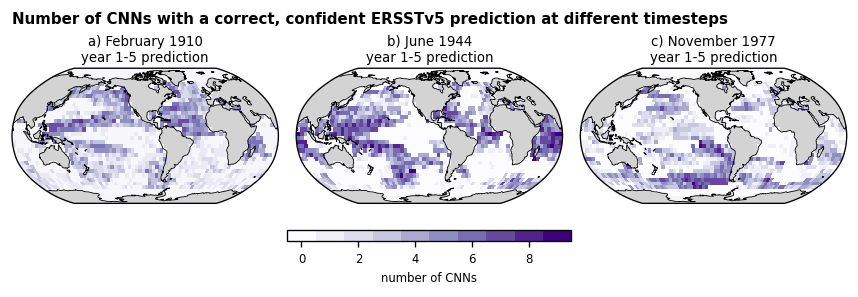

In [10]:
fig = plt.figure(figsize = (7.4, 2.3))
lead = 0
length = 60

correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")
correct_conf_timestep = correct_conf_ds.sum(dim = ["model", "variant"])

i = 0
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(xr.where(land_mask.mask == 0, np.nan, correct_conf_timestep.sel(time = t1).sst), 
                  lons, lats, ax, VMIN = -0.5, VMAX = 9.5, CMAP = "Purples", legend = False)
ax.set_title("a) February 1910\nyear 1-5 prediction", y = 1.05, transform = ax.transAxes)

i = 1
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(xr.where(land_mask.mask == 0, np.nan, correct_conf_timestep.sel(time = t2).sst), 
                  lons, lats, ax, VMIN = -0.5, VMAX = 9.5, CMAP = figu.purples, legend = False)
ax.set_title("b) June 1944\nyear 1-5 prediction", y = 1.05, transform = ax.transAxes)

cbaxes = fig.add_axes([0.34, 0.15, 0.32, .04]) 
cbar = fig.colorbar(p, cax = cbaxes, label = 'number of CNNs', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)


i = 2
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(xr.where(land_mask.mask == 0, np.nan, correct_conf_timestep.sel(time = t3).sst), 
                  lons, lats, ax, VMIN = -0.5, VMAX = 9.5, CMAP = figu.purples, legend = False)
ax.set_title("c) November 1977\nyear 1-5 prediction", y = 1.05, transform = ax.transAxes)


plt.suptitle("Number of CNNs with a correct, confident ERSSTv5 prediction at different timesteps", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/Fig_S15_window_of_opportunity_agreement.pdf")

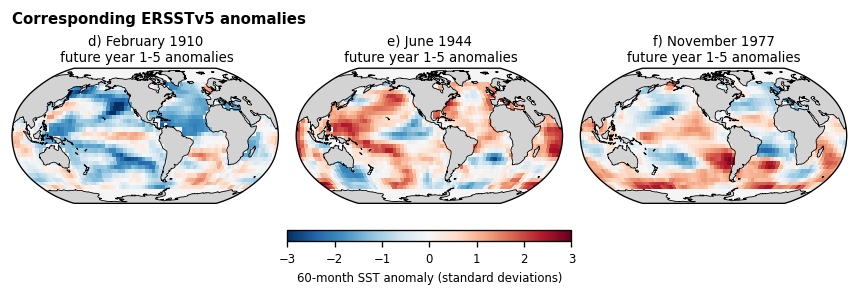

In [11]:
fig = plt.figure(figsize = (7.4, 2.3))
lead = 0
length = 60

_, _, prediction_dates = utils.get_prediction_dates(obs_dates, input_length, lead, length)

_, y_obs = read.load_xy_obs(obs_dates, input_length, lead, length, X_VAR_NAME = "sst", Y_VAR_NAME = "sst", 
                                 DATASET="ERSSTv5")
y_obs = xr.DataArray(data = y_obs.reshape(len(prediction_dates), len(lats), len(lons)), 
                      coords = dict(time = prediction_dates, lat = lats, lon = lons), 
                      name = "tos")
y_obs.loc[dict(lat=na_lats)] = np.nan

i = 0
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(y_obs.sel(time = t1), lons, lats, ax, CMAP = "RdBu_r", VMIN = -3, VMAX = 3, legend = False)
ax.set_title("d) February 1910\n future year 1-5 anomalies", y = 1.05, transform = ax.transAxes)

i = 1
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(y_obs.sel(time = t2), lons, lats, ax, CMAP = "RdBu_r", VMIN = -3, VMAX = 3, legend = False)
ax.set_title("e) June 1944\n future year 1-5 anomalies", y = 1.05, transform = ax.transAxes)

cbaxes = fig.add_axes([0.34, 0.15, 0.32, .04]) 
cbar = fig.colorbar(p, cax = cbaxes, label = '60-month SST anomaly (standard deviations)', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)

i = 2
ax = fig.add_axes([.03 + i*0.32, 0.18, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
p = figu.plot_map(y_obs.sel(time = t3), lons, lats, ax, CMAP = "RdBu_r", VMIN = -3, VMAX = 3, legend = False)
ax.set_title("f) November 1977\nfuture year 1-5 anomalies", y = 1.05, transform = ax.transAxes)

plt.suptitle("Corresponding ERSSTv5 anomalies", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/Fig_S15_anomalies.pdf")

In [12]:
import seaborn as sns

In [13]:
sns.set_palette("Blues_d", n_colors = 9) #Blues_d, gist_earth

In [14]:
lead = 0
length = 60

In [15]:
correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")

In [16]:
timestep_correct_predictions = correct_conf_ds.sum(dim = ["model", "variant", "lat", "lon"]).sst
ds = correct_conf_ds

In [17]:
ds.rio.write_crs('epsg:4326', inplace = True)
ds.rio.set_spatial_dims("lon", "lat", inplace=True)
land_mask.rio.write_crs('epsg:4326', inplace = True)
land_mask.rio.set_spatial_dims("lon", "lat", inplace=True)

<xarray.Dataset>
Dimensions:      (lat: 36, lon: 72)
Coordinates:
    time         datetime64[ns] 1854-01-01
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
    spatial_ref  int64 0
Data variables:
    mask         (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1

In [18]:
def get_region_correct_timeseries(REGION, ds):
    poly = gpd.read_file("../processed_data/"+REGION+".shp")
    ds_clip = ds.rio.clip(poly.geometry.values)
    region_correct_ds = ds_clip.sum(dim = ["variant", "lat", "lon"]).sst
    return(region_correct_ds)

In [19]:
poly = gpd.read_file("../processed_data/"+REGION+".shp")
land_mask_clip = land_mask.rio.clip(poly.geometry.values)

NameError: name 'gpd' is not defined

In [ ]:
get_region_correct_timeseries(REGION, ds)

In [ ]:
N_cells = land_mask_clip.sum().mask.values

In [ ]:
fig = plt.figure(figsize = (7, 3.2))

ax_width = 0.9

REGION = "north_pacific"

ax = fig.add_axes([0.08, 0.4, ax_width, 0.5])
p = get_region_correct_timeseries(REGION, ds).plot.line(hue = "model", ax = ax, linewidth = 0.5, alpha = 0.8, 
                                                       add_legend=False)
ax.set(xlim = (prediction_dates[0], prediction_dates[-1]), xlabel = "", title = "")
plt.ylabel("region grid cells\nwith correct, confident prediction")
ax.get_xaxis().set_ticklabels([])

ax = fig.add_axes([0.08, 0.1, ax_width, 0.25])
poly = gpd.read_file("../processed_data/"+REGION+".shp")
ds_clip = y_obs.rio.clip(poly.geometry.values)
region_ts = ds_clip.mean(dim = ["variant", "lat", "lon"]).plot(ax = ax, color = "black")
plt.axhline(0, linestyle = "dashed", color = "gray")
ax.set(xlim=(prediction_dates[0], prediction_dates[-1]), title = "")
plt.ylabel("region mean\nSST anomaly")

plt.suptitle("Timeseries of correct, confident predictions in the North Pacific (year 1-5)", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/supp_correct_confident_timeseries.pdf")

In [ ]:
fig = plt.figure(figsize = (12, 18))
label_count = 0

ax_width = 0.8
ax_height = 0.111

for i, (REGION, region_label) in enumerate(zip(regions, region_labels)):
    ax = fig.add_axes([0.08, 0.82 - i*(ax_height+0.019), ax_width, ax_height])
    get_region_correct_timeseries(REGION, ds).plot.line(hue = "model", ax = ax, linewidth = 0.5, alpha = 0.8)

In [ ]:
poly = gpd.read_file("../processed_data/north_pacific.shp")
ds_clip = correct_conf_ds.rio.clip(poly.geometry.values)

In [ ]:
x = ds_clip.sel(model = "IPSL-CM6A-LR", variant = "obs_variant").sum(dim = ["lat", "lon"])
x.sst.plot()

In [ ]:
x.time

In [ ]:
y.isel(variant = 0).mean(dim = "time").plot()

In [ ]:
_, _, prediction_dates = utils.get_prediction_dates(obs_dates, input_length, lead, length)
_, y_obs = read.load_xy_obs(obs_dates, input_length, lead, length, 
                              X_VAR_NAME = "sst", Y_VAR_NAME = "sst", 
                                 DATASET="ERSSTv5")
y_obs = xr.DataArray(data = y_obs.reshape(1, len(prediction_dates), len(lats), len(lons)), 
                      coords = dict(variant = ["obs_variant"], time = prediction_dates, lat = lats, lon = lons), 
                      name = "tos")

y_obs.rio.write_crs('epsg:4326', inplace = True)
y_obs.rio.set_spatial_dims("lon", "lat", inplace=True)

In [ ]:
ds_clip

In [ ]:
fig = plt.figure(figsize = (7, 9))
label_count = 0

ax_width = 0.8
ax_height = 0.111

for i, (REGION, region_label) in enumerate(zip(regions, region_labels)):
    ax = fig.add_axes([0.08, 0.82 - i*(ax_height+0.019), ax_width, ax_height])
    poly = gpd.read_file("../processed_data/"+REGION+".shp")
    ds_clip = y_obs.rio.clip(poly.geometry.values)
    region_ts = ds_clip.mean(dim = ["variant", "lat", "lon"]).plot(ax = ax)
    
    

In [ ]:
timestep_correct_predictions.plot()

In [ ]:
model_correct_predictions.plot.line(hue = "model")

In [ ]:
ds = correct_conf_ds

In [ ]:
import geopandas as gpd

In [ ]:
regions = ["north_pacific", "tropical_pacific", "southern_ocean", "north_atlantic", "tropical_atlantic", "west_indian"]
region_labels = ["N. Pacific", "Tropical Pac.", "S. Ocean", "N. Atlantic", "Tropical Atl.", "W. Indian"]

In [ ]:
REGION = "north_pacific"

In [ ]:
fig = plt.figure(figsize = (7.4, 2.3))

panel_labels = ["a", "b", "c"]
time_labels = ["year 1-3", "year 1-5", "years 3-7"]
for i, (lead, length) in enumerate(zip(leads, prediction_lengths)): 
    correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")

    N_days = len(correct_conf_ds.time)
    max_correct_conf_single_CNN = correct_conf_ds.sum(dim = "time").max(dim = "model").isel(variant = 0).sst
    max_correct_conf_single_CNN = xr.where(land_mask.mask == 0, np.nan, max_correct_conf_single_CNN)

    ax = fig.add_axes([.03 + i*0.32, 0.22, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
    p = figu.plot_map(max_correct_conf_single_CNN/N_days, lons, lats, ax, VMIN = 0.05, VMAX = 0.2, CMAP = "YlGnBu", legend = False)
    ax.set_title(panel_labels[i]+") "+time_labels[i], y = 1.05, transform = ax.transAxes)


get_region_correct_timeseries("west_indian", ds).plot.line(hue = "model")
plt.ylim((5, 40))

In [ ]:
poly = gpd.read_file("../processed_data/"+REGION+".shp")

In [ ]:
ds_clip = ds.rio.clip(poly.geometry.values)

In [ ]:
ds_clip.isel(time = 0, variant = 0, model = 0).sst.plot()

In [ ]:
def get_region_mean(ds, poly, land_mask):
    ds.rio.write_crs('epsg:4326', inplace = True)
    ds.rio.set_spatial_dims("lon", "lat", inplace=True)
    land_mask.rio.write_crs('epsg:4326', inplace = True)
    land_mask.rio.set_spatial_dims("lon", "lat", inplace=True)

    ds_clip = ds.rio.clip(poly.geometry.values)
    weights = utils.get_cell_weights(land_mask.rio.clip(poly.geometry.values))
    
    return((ds_clip*weights.mask).mean(skipna = True, dim = ["lat", "lon"]).score.values)

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1900-01-01", "1920-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1900-01-01", "1920-01-01")).time[85].values)
print(timestep_correct_predictions.sel(time = "1907-02-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1907-02-01").sst.plot()

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1940-01-01", "1960-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1940-01-01", "1960-01-01")).time[53].values)
print(timestep_correct_predictions.sel(time = "1944-06-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1944-06-01").sst.plot()

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1975-01-01", "1985-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1975-01-01", "1985-01-01")).time[34].values)
print(timestep_correct_predictions.sel(time = "1977-11-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1977-11-01").sst.plot()

#### best prediction timesteps for 24 month lead 60 month predictions

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1900-01-01", "1920-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1900-01-01", "1920-01-01")).time[65].values)
print(timestep_correct_predictions.sel(time = "1905-06-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1905-06-01").sst.plot()

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1975-01-01", "1985-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1975-01-01", "1985-01-01")).time[16].values)
print(timestep_correct_predictions.sel(time = "1976-05-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1976-05-01").sst.plot()

In [ ]:
print(timestep_correct_predictions.sel(time = slice("1940-01-01", "1960-01-01")).argmax().values)
print(timestep_correct_predictions.sel(time = slice("1940-01-01", "1960-01-01")).time[32].values)
print(timestep_correct_predictions.sel(time = "1942-09-01").values)

In [ ]:
correct_conf_ds.sum(dim = ["model", "variant"]).sel(time = "1942-09-01").sst.plot()

In [ ]:
fig = plt.figure(figsize = (7.4, 2.3))

panel_labels = ["a", "b", "c"]
time_labels = ["year 1-3", "year 1-5", "years 3-7"]
for i, (lead, length) in enumerate(zip(leads, prediction_lengths)): 
    correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")

    correct_conf_days_multimodel = xr.where(correct_conf_ds.sel(variant = "obs_variant").sum(dim = "model").sst > 2, 1, np.nan).sum(dim = "time")
    correct_conf_days_multimodel = xr.where(land_mask == 1, np.nan, correct_conf_days_multimodel)
    
    ax = fig.add_axes([.03 + i*0.32, 0.22, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
    p = figu.plot_map(correct_conf_days_multimodel, lons, lats, ax, VMIN = 0, VMAX = 500, CMAP = "YlGnBu", legend=False)
    ax.set_title(panel_labels[i]+") "+time_labels[i], y = 1.05, transform = ax.transAxes)

    cbaxes = fig.add_axes([.06 + i*0.32, 0.2, 0.24, .04]) 
    cbar = fig.colorbar(p, cax = cbaxes, label = 'number of predictions', orientation = "horizontal")
    cbar.ax.tick_params(labelsize=7)

plt.suptitle("Number of CNNs with correct, confident ERSSTv5 predictions at different timesteps", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/supp_number_correct_confident_multimodel.pdf")

In [ ]:
fig = plt.figure(figsize = (7.4, 2.3))

panel_labels = ["a", "b", "c"]
time_labels = ["year 1-3", "year 1-5", "years 3-7"]
for i, (lead, length) in enumerate(zip(leads, prediction_lengths)): 
    correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")

    N_days = len(correct_conf_ds.time)
    total_correct_conf_days = xr.where(correct_conf_ds.sel(variant = "obs_variant").sum(dim = "model").sst > 0, 1, np.nan).sum(dim = "time")
    total_correct_conf_days = xr.where(land_mask.mask == 0, np.nan, total_correct_conf_days)
    
    ax = fig.add_axes([.03 + i*0.32, 0.22, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
    p = figu.plot_map(total_correct_conf_days/N_days, lons, lats, ax, 
                      VMIN = 0.2, VMAX = 0.5, CMAP = "YlGnBu", legend=False)
    ax.set_title(panel_labels[i]+") "+time_labels[i], y = 1.05, transform = ax.transAxes)

    if i==1:
        cbaxes = fig.add_axes([0.34, 0.18, 0.32, .04]) 
        cbar = fig.colorbar(p, cax = cbaxes, label = 'fraction of total prediction timesteps', orientation = "horizontal")
        cbar.ax.tick_params(labelsize=7)

plt.suptitle("Number of timesteps with a correct, confident ERSSTv5 prediction by at least one CNNs", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/supp_number_correct_confident_predictions.pdf")

In [ ]:
fig = plt.figure(figsize = (7.4, 2.3))

panel_labels = ["a", "b", "c"]
time_labels = ["year 1-3", "year 1-5", "years 3-7"]
for i, (lead, length) in enumerate(zip(leads, prediction_lengths)): 
    correct_conf_ds = xr.open_dataset("../processed_data/correct_confident_predictions_"+str(length)+"mo_"+str(lead)+"lead.nc")

    N_days = len(correct_conf_ds.time)
    max_correct_conf_single_CNN = correct_conf_ds.sum(dim = "time").max(dim = "model").isel(variant = 0).sst
    max_correct_conf_single_CNN = xr.where(land_mask.mask == 0, np.nan, max_correct_conf_single_CNN)

    ax = fig.add_axes([.03 + i*0.32, 0.22, 0.3, .7], projection = ccrs.Robinson(central_longitude = 260))
    p = figu.plot_map(max_correct_conf_single_CNN/N_days, lons, lats, ax, VMIN = 0.05, VMAX = 0.2, CMAP = "YlGnBu", legend = False)
    ax.set_title(panel_labels[i]+") "+time_labels[i], y = 1.05, transform = ax.transAxes)

    if i==1:
        cbaxes = fig.add_axes([0.34, 0.18, 0.32, .04]) 
        cbar = fig.colorbar(p, cax = cbaxes, label = 'fraction of total prediction timesteps', orientation = "horizontal")
        cbar.ax.tick_params(labelsize=7)

plt.suptitle("Maximum number of timesteps with a correct, confident ERRSTv5 prediction by a single CNN", 
             y = 0.98, x = 0.03, size = 9, ha = "left", weight = "bold")

plt.savefig("../figures/supp_max_correct_confident_predictions_single_CNN.pdf")
